In [1]:
import os
import numpy as np
import pandas as pd
from argparse import ArgumentParser

import random
import patsy as pat
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [13]:
def standardize(mask,data):
    scaler = StandardScaler(with_mean=False, with_std=True)
    scaler.fit(data[mask])
    standardized=scaler.transform(data)
    return standardized

# redefined function from util to only generate standardized betamaps
def case_control(p,case,regressors,conn):
    """
    pheno = dataframe:
        -filtered to be only relevant subjects for case control (use mask_cc)
        -case column is onehot encoded
    case = column from pheno
    regressors = list of strings, formatted for patsy
    connectomes = n_subjects x n_edges array
    
    Returns:
    table = n_edges
        - betas_std = including standardization on controls
        - pvalues = pvalues
        - qvalues = fdr corrected pvalues alpha = 0.05
    """
    n_edges = conn.shape[1]

    betas_std = np.zeros(n_edges)

    formula = ' + '.join((regressors + [case]))
    dmat = pat.dmatrix(formula, p, return_type='dataframe',NA_action='raise')
    
    mask_std = ~p[case].to_numpy(dtype=bool)
    conn_std = standardize(mask_std, conn)
    
    for edge in range(n_edges):
        model_std = sm.OLS(conn_std[:,edge],dmat)
        results_std = model_std.fit()
        betas_std[edge] = results_std.params[case]
    
    table = pd.DataFrame(np.array([betas_std]).transpose(),
                         columns=['betas_std'])
    return table

# Load Data

In [14]:
path_pheno = '/Users/harveyaa/Documents/masters/data/pheno_26-01-22.csv'
pheno = pd.read_csv(path_pheno,index_col=0)

/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/3622504503.py:2: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno = pd.read_csv(path_pheno,index_col=0)


In [4]:
path_conn = '/Users/harveyaa/Documents/masters/data/connectomes_01-12-21.csv'
conn = pd.read_csv(path_conn,index_col=0)

In [15]:
age_sites = ['USM',
        'SZ3',
        'SZ6',
        'Svip2',
        'ADHD6',
        'HSJ',
        'SZ2',
        'SZ1',
        'UCLA_CB',
        'Svip1',
        'UKBB11026',
        'UKBB11027',
        'UKBB11025',
        'ADHD1',
        'ADHD3',
        'NYU',
        'ADHD5',
        'UCLA_DS1']

path_ids = '/Users/harveyaa/Documents/masters/neuropsych_mtl/datasets/cv_folds/age_sex/'

In [16]:
site_ids = []
for site in age_sites:
    if site[:4] == 'UKBB':
        site = site+'_50'
    ids = pd.read_csv(os.path.join(path_ids, f"{site}.csv"),index_col=0).index
    site_ids.append(ids)
site_ids = dict(zip(age_sites,site_ids))

# Calculate ES (by site)

In [17]:
regressors = ['C(SEX)','FD_scrubbed', 'mean_conn']

age_mtd = []
for site in age_sites:

    pheno_site = pheno.loc[pheno.index.isin(site_ids[site])]
    n_young = int(len(pheno_site)/2)
    pheno_site.sort_values('AGE',inplace=True)
    pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
    pheno_site.sort_index(inplace=True)

    betamap = case_control(pheno_site,
                'AGE_01',
                regressors,
                conn.loc[conn.index.isin(site_ids[site])].values)['betas_std']

    rank = pd.qcut(betamap.abs(),10,labels=False)
    decile_idx = rank[rank==9].index
    mtd = np.mean(betamap.abs()[decile_idx])
    age_mtd.append(mtd)
df_mtd = pd.DataFrame(age_mtd,index=age_sites,columns=['mtd'])

/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/3509714646.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/3509714646.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/3509714646.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

In [21]:
regressors = ['C(SEX)','FD_scrubbed', 'mean_conn']

cv_es = []
for k in [2,3,5]:
    cc_rows = []
    for site in age_sites:
        print(site,' ',k)
        pheno_site = pheno.loc[pheno.index.isin(site_ids[site])]
        n_young = int(len(pheno_site)/2)
        pheno_site.sort_values('AGE',inplace=True)
        pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
        pheno_site.sort_index(inplace=True)

        idx = site_ids[site]
        strat_col = pheno_site['AGE_01']

        skf = StratifiedKFold(n_splits=k)

        es_train = []
        es_test = []
        k=0
        for train_index, test_index in skf.split(idx, strat_col):
            betamap_train = case_control(pheno_site.loc[idx[train_index]],
                                            'AGE_01',
                                            regressors,
                                            conn.loc[idx[train_index]].to_numpy())['betas_std']

            rank = pd.qcut(betamap_train.abs(),10,labels=False)
            decile_idx = rank[rank==9].index

            # Get train ES
            decile_train = betamap_train.abs()[decile_idx]
            mtd_train = np.mean(decile_train)
            es_train.append(mtd_train)

            betamap_test = case_control(pheno_site.loc[idx[test_index]],
                                            'AGE_01',
                                            regressors,
                                            conn.loc[idx[test_index]].to_numpy())['betas_std']
            # Get test ES
            decile_test = betamap_test.abs()[decile_idx]
            mtd_test = np.mean(decile_test)
            es_test.append(mtd_test)

            k += 1

        cc_rows.append([np.mean(es_train),np.mean(es_test)])

    df_cc = pd.DataFrame(cc_rows,columns=[f'train_ES_{k}',f'test_ES_{k}'],index=age_sites)
    cv_es.append(df_cc)

USM   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

SZ3   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

SZ6   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

Svip2   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

ADHD6   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

HSJ   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

SZ2   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

SZ1   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UCLA_CB   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

Svip1   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UKBB11026   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UKBB11027   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UKBB11025   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

ADHD1   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

ADHD3   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

NYU   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

ADHD5   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UCLA_DS1   2


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

USM   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

SZ3   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

SZ6   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

Svip2   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

ADHD6   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

HSJ   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

SZ2   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

SZ1   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UCLA_CB   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

Svip1   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UKBB11026   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UKBB11027   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UKBB11025   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

ADHD1   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

ADHD3   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

NYU   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

ADHD5   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UCLA_DS1   3


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

USM   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

SZ3   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

SZ6   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

Svip2   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

ADHD6   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

HSJ   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

SZ2   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

SZ1   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UCLA_CB   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

Svip1   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UKBB11026   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UKBB11027   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UKBB11025   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

ADHD1   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

ADHD3   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

NYU   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

ADHD5   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

UCLA_DS1   5


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site.sort_values('AGE',inplace=True)
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno_site['AGE_01'] = n_young*[0]+(len(pheno_site)-n_young)*[1]
/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/610918058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

In [22]:
df_cv = pd.concat(cv_es,axis=1)
df_age = pd.concat([df_mtd,df_cv],axis=1)
df_age

,mtd,train_ES_2,test_ES_2,train_ES_3,test_ES_3,train_ES_5,test_ES_5
USM,0.764509,1.132359,0.451143,0.931287,0.579388,0.855388,1.203378
SZ3,0.874829,1.753874,0.588553,1.169738,0.870443,1.024973,5.772502
SZ6,0.781702,1.413942,0.496196,1.038031,0.759704,0.900513,1.577601
Svip2,0.942339,1.664893,0.594889,1.217237,0.829897,1.042979,2.166504
ADHD6,0.706582,1.144653,0.381017,0.906519,0.539621,0.804333,1.188391
HSJ,0.809507,1.304139,0.483406,1.042123,0.646658,0.946554,1.378381
SZ2,0.505704,0.912210,0.376250,0.727543,0.541137,0.604654,0.885347
SZ1,0.673683,1.042104,0.394151,0.856059,0.576402,0.768036,1.489382
UCLA_CB,0.730380,1.105966,0.401428,0.922064,0.597079,0.815648,1.397368
Svip1,0.782033,1.154469,0.454669,0.926019,0.605744,0.837862,0.830476


/var/folders/5x/9dwn0lbx633gccy22ts5bskh0000gn/T/ipykernel_70302/508636987.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_age.index, rotation=90)


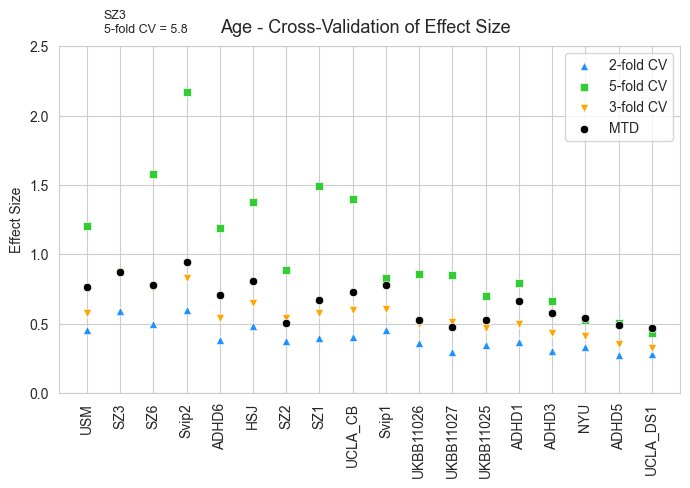

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

colors = ['navy','darkorchid','red','orange','dodgerblue','forestgreen']
colors2 = ['dodgerblue','limegreen','orange','black','forestgreen']

cp = sns.color_palette(colors2)
sns.set_palette(cp)
fig, ax = plt.subplots(figsize=(7,5))
sns.scatterplot(data = df_age, x = df_age.index,y = 'test_ES_2',label='2-fold CV',marker='^')
sns.scatterplot(data = df_age, x = df_age.index,y = 'test_ES_5',label='5-fold CV',marker='s')
sns.scatterplot(data = df_age, x = df_age.index,y = 'test_ES_3',label='3-fold CV',marker='v')
sns.scatterplot(data = df_age, x = df_age.index,y = 'mtd',label='MTD')
plt.legend(loc='upper right')
ax.set_xticklabels(df_age.index, rotation=90)
ax.set_ylabel('Effect Size')
#plt.suptitle('AGE - Cross-Validation of Effect Size')
plt.text(4,2.6,'Age - Cross-Validation of Effect Size',fontsize=13)
plt.ylim(0,2.5)
plt.text(0.5,2.6,'SZ3\n5-fold CV = 5.8', fontsize=9)
plt.tight_layout()
plt.savefig('./results/age_effect_size_cv.png',dpi=300)